In [107]:
import pandas as pd
from linearmodels import PanelOLS
import numpy as np

def prepare_data():
    """Prepare data for regression analysis"""
    # Define the file path for the .dta file
    filepath = r'at.dta'
    
    # Load the .dta file
    df = pd.read_stata(filepath)
    
    # Convert to panel format
    df = df.set_index(['app_num', 'ym'])
    
    # Fill in null values of 'Feature_Update' with 0
    df['Feature_Update'] = df['Feature_Update'].fillna(0)
    
    # Drop rows with NaN in the dependent variable (Rating)
    df = df.dropna(subset=['Rating'])
    
    # Create AFTER_BAN variable for when ban was enforced
    df['AFTER_BAN'] = (df.index.get_level_values('ym') >= 716).astype(int)
    
    # Create TREATXAFTER_BAN variable
    df['TREATXAFTER_BAN'] = df['ann_TREAT'] * df['AFTER_BAN']
    
    return df

def generate_summary_statistics(data):
    """Generate summary statistics for main variables"""
    variables = ['Rating', 'Log_Demand', 'Age', 'Price',
                 'Log_Firm_Size', 'One_Employee', 'Feature_Update']
    
    summary_stats = data[variables].agg(['mean', 'std', 'min', 'median', 'max']).T
    summary_stats.columns = ['Mean', 'Std Dev', 'Min', 'Median', 'Max']
    
    return summary_stats

def print_summary_statistics(summary_stats):
    """Print formatted summary statistics"""
    print("\nSummary Statistics:")
    print("-" * 80)
    print(summary_stats.to_string(float_format=lambda x: f"{x:.4f}"))
    print("-" * 80)

def run_ratings_model(data, model_type='full', treatment_var='TREATXAFTER_BAN'):
    """Run the DiD model for the Ratings dependent variable"""
    if model_type == 'basic':
        exog_vars = [treatment_var, 'genre_cons']
    elif model_type == 'full':
        exog_vars = [treatment_var, 'genre_cons', 'Log_Demand', 'Feature_Update', 'Price', 'Log_Firm_Size', 'One_Employee', 'Age']
    elif model_type == 'no_feature_update':
        exog_vars = [treatment_var, 'genre_cons', 'Log_Demand', 'Price', 'Log_Firm_Size', 'One_Employee', 'Age']
    
    # Create the model
    model = PanelOLS(
        dependent=data['Rating'],
        exog=data[exog_vars],
        entity_effects=True,
        time_effects=True,
        check_rank=False
    )
    
    # Fit with clustered standard errors
    results = model.fit(cov_type='clustered', cluster_entity=True)
    
    return results

def print_formatted_results(results, model_type, treatment_var):
    """Print formatted results for the Ratings model"""
    print(f"\nResults for Rating ({model_type} model, using {treatment_var}):")
    print("-" * 50)
    
    # Print coefficients and standard errors for all variables
    for var in results.params.index:
        coef = results.params[var]
        se = results.std_errors[var]
        stars = ''
        pval = results.pvalues[var]
        if pval < 0.01:
            stars = '***'
        elif pval < 0.05:
            stars = '**'
        elif pval < 0.1:
            stars = '*'
        print(f"{var}: {coef:.4f}{stars} ({se:.4f})")
    
    print(f"\nObservations: {results.nobs:,}")
    print("Game fixed effects: x")
    print("Month fixed effects: x")
    print(f"R-squared: {results.rsquared:.4f}")
    
    # Calculate adjusted R-squared
    n = results.nobs
    k = len(results.params)
    adj_r_squared = 1 - (1 - results.rsquared) * (n - 1) / (n - k)
    print(f"Adj. R-squared: {adj_r_squared:.4f}")
    
    # Print F-Statistic
    print(f"F-statistic: {results.f_statistic.stat:.4f}")
    print(f"Prob (F-statistic): {results.f_statistic.pval:.4f}")

def main():
    # Prepare the data
    df = prepare_data()

    # Generate and print summary statistics
    summary_stats = generate_summary_statistics(df)
    print_summary_statistics(summary_stats)
    
    # Run models with TREATXAFTER_BAN
    basic_model_results_enforced = run_ratings_model(df, model_type='basic', treatment_var='TREATXAFTER_BAN')
    full_model_results_enforced = run_ratings_model(df, model_type='full', treatment_var='TREATXAFTER_BAN')
    no_feature_update_model_results_enforced = run_ratings_model(df, model_type='no_feature_update', treatment_var='TREATXAFTER_BAN')
    
    # Print formatted results for each model
    print_formatted_results(basic_model_results_enforced, 'Basic', 'TREATXAFTER_BAN')
    print_formatted_results(full_model_results_enforced, 'Full', 'TREATXAFTER_BAN')
    print_formatted_results(no_feature_update_model_results_enforced, 'No Feature Update', 'TREATXAFTER_BAN')
    
    return (summary_stats, basic_model_results_enforced, full_model_results_enforced, no_feature_update_model_results_enforced, df)

if __name__ == "__main__":
    results = main()


Summary Statistics:
--------------------------------------------------------------------------------
                   Mean  Std Dev    Min   Median       Max
Rating           4.0619   0.5226 1.0000   4.1000    5.0000
Log_Demand       6.7327   2.8517 0.6931   6.7310   15.7162
Age            730.9052 618.2471 1.0000 537.0000 3639.0000
Price            0.0039   0.0620 0.0000   0.0000    1.0000
Log_Firm_Size    2.5776   1.2348 0.6931   2.5649    7.2392
One_Employee     0.8549   0.3523 0.0000   1.0000    1.0000
Feature_Update   0.0294   0.1690 0.0000   0.0000    1.0000
--------------------------------------------------------------------------------

Results for Rating (Basic model, using TREATXAFTER_BAN):
--------------------------------------------------
TREATXAFTER_BAN: 0.0274*** (0.0094)
genre_cons.Adventure and Strategy: -0.0175 (0.0385)
genre_cons.Arcade: 0.0663 (0.0406)
genre_cons.Board and Puzzle: -0.1437** (0.0694)
genre_cons.Card: 0.0832 (0.2126)
genre_cons.Casino: -0.0722 (0.06

In [ ]:
from sklearn import tree
sqft_tree = tree.DecisionTreeRegressor(max_depth=3).fit(X,Y)
# use the fitted tree to predict
y_pred_tree = sqft_tree.predict(X)

# find the error of prediction (MSE)
from sklearn import metrics
print('Mean Squared Error:', metrics.mean_squared_error(Y, y_pred_tree))
sqrf_fig = plt.figure(figsize=(25,20))
sqrf_fig = tree.plot_tree(sqft_tree, feature_names=X.columns, filled=True)

In [ ]:
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
clf = DTC(criterion='entropy',
          max_depth=3,
          random_state=0)        
clf.fit(X, y)

ax = subplots(figsize=(12,12))[1]
feature_names = X.columns
plot_tree(clf,
          feature_names=feature_names,
          ax=ax);


In [ ]:
#Random Forest: using 5 features

# define and fit
regr_clf = RandomForestClassifier(max_features=5, random_state=1).fit(X, y)

#predict
pred = regr_clf.predict(X)

#calculate MSE
rf_mse = mean_squared_error(y, pred)
Importance = pd.DataFrame({'Importance':regr_clf.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.title('Importance Score Plot')
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [ ]:
import xgboost as xgb
from sklearn.model_selection import cross_val_predict

# Convert the data into XGBoost's DMatrix format
dtrain = xgb.DMatrix(X, label=y)

# Define the parameters for the XGBoost model
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train the XGBoost model with the optimal number of boosting rounds
model = xgb.train(params, dtrain, num_boost_round= 10)

# Make predictions 
y_pred = model.predict(dtrain)

# Calculate and print the Mean Squared Error (MSE)
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)


plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, c='grey', alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('True Y')
plt.ylabel('Predicted Y')
plt.title('Y vs Predicted Y (Y hat)')
plt.show()

In [ ]:
# Define cross-validation strategy
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize LassoCV with cross-validation and a custom range of alphas
custom_alphas = np.logspace(-5, 1, 100)  # Custom range of alphas
lassoCV = LassoCV(
    alphas=custom_alphas,  # Use the custom alphas
    cv=kfold,
    max_iter=100000,
    tol=1e-4,
    random_state=42
)

# Create a pipeline with scaler and LassoCV
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])

# Fit the pipeline to the data
pipeCV.fit(X, Y)
print("\nLassoCV model fitted successfully.")

# Retrieve the tuned alpha (regularization parameter)
tuned_lasso = pipeCV.named_steps['lasso']
best_alpha = tuned_lasso.alpha_
print(f"\nOptimal alpha determined by cross-validation: {best_alpha}")

# ------------------------------------------------------------
# Plotting Cross-validated MSE with Error Bars
# ------------------------------------------------------------

# Extract the cross-validated MSEs and standard deviations
mse_path_mean = np.mean(tuned_lasso.mse_path_, axis=1)
mse_path_std = np.std(tuned_lasso.mse_path_, axis=1)

# Plotting the cross-validated MSE vs. -log(lambda) with error bars
plt.figure(figsize=(8, 8))
plt.errorbar(-np.log10(tuned_lasso.alphas_), mse_path_mean, yerr=mse_path_std / np.sqrt(5), fmt='o-')
plt.axvline(-np.log10(best_alpha), color='k', linestyle='--')
plt.xlabel('$-\\log(\\lambda)$', fontsize=20)
plt.ylabel('Cross-validated MSE', fontsize=20)
plt.title('Lasso Regression Cross-Validated MSE', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Plotting Lasso Coefficients Path
# ------------------------------------------------------------

# Compute the Lasso path (coefficients for different alphas)
X_scaled = scaler.transform(X)  # Lasso expects standardized data

# Define a range of alpha values (logarithmically spaced)
num_alphas = 100
alphas_lasso = np.logspace(-5, 1, num_alphas)

# Compute the Lasso path
alphas_lasso, coefs_lasso, _ = lasso_path(X_scaled, Y, alphas=alphas_lasso)

# Create a DataFrame for the solution path
feature_names = X.columns
soln_path = pd.DataFrame(coefs_lasso.T, columns=feature_names, index=-np.log10(alphas_lasso))

# Plot the Lasso coefficient path
plt.figure(figsize=(10, 6))
for feature in feature_names:
    plt.plot(soln_path.index, soln_path[feature], label=feature)

plt.xlabel('$-\\log(\\lambda)$', fontsize=14)
plt.ylabel('Standardized Coefficients', fontsize=14)
plt.title('Lasso Regression Plot', fontsize=16)
plt.legend(title='Features')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Define a range of lambda values (regularization strengths)
lambda_min_exponent = -5
lambda_max_exponent = 8
num_lambdas = 100
lambdas = 10 ** np.linspace(lambda_max_exponent, lambda_min_exponent, num_lambdas)

# Fit Elastic Net model paths with l1_ratio=0 (Ridge Regression)
alphas, coefs, _ = enet_path(X_scaled, Y, l1_ratio=0.0, alphas=lambdas)

# Create a DataFrame for the solution path
coef_df = pd.DataFrame(coefs, index=['TREATXAFTER', 'Age', 'Log_Firm_Size', 'Price', 'One_Employee'], columns=-np.log(alphas))

# Plot the solution path
plt.figure(figsize=(10, 6))
for feature in coef_df.index:
    plt.plot(coef_df.columns, coef_df.loc[feature], label=feature)

plt.xlabel('$-\log(\lambda)$', fontsize=14)
plt.ylabel('Standardized Coefficients', fontsize=14)
plt.title('Ridge Regression Plot', fontsize=16)
plt.legend(title='Features')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Define a range of lambda values (regularization strengths)
lambda_min_exponent = -8
lambda_max_exponent = 8
num_lambdas = 100
lambdas = 10 ** np.linspace(lambda_max_exponent, lambda_min_exponent, num_lambdas)

# Set up the pipeline with scaling and Ridge regression
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

# Set up the parameter grid for alpha (lambda)
param_grid = {'ridge__alpha': lambdas}

# Use GridSearchCV to perform cross-validation over the lambdas
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X, Y)

# Get the cross-validated MSEs and standard deviations
mean_test_scores = -grid_search.cv_results_['mean_test_score']
std_test_scores = grid_search.cv_results_['std_test_score']

# Get the best alpha (lambda) value
best_alpha = grid_search.best_estimator_.named_steps['ridge'].alpha

# Plotting the cross-validated MSE vs. -log(lambda)
plt.figure(figsize=(8, 8))
plt.errorbar(-np.log(lambdas), mean_test_scores, yerr=std_test_scores / np.sqrt(5), fmt='o-')
plt.axvline(-np.log(best_alpha), color='k', linestyle='--')
plt.xlabel('$-\\log(\\lambda)$', fontsize=20)
plt.ylabel('Cross-validated MSE', fontsize=20)
plt.title('Ridge Regression Cross-Validated MSE', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# Get and print the best alpha (lambda) value
best_alpha = grid_search.best_estimator_.named_steps['ridge'].alpha
print(f"Optimal alpha (lambda) value: {best_alpha}")



In [ ]:
#Bagging; using all features

regr_bagg = RandomForestClassifier(max_features= 18, random_state=1) 
regr_bagg.fit(X, y)


pred = regr_bagg.predict(X)

plt.scatter(pred, y, label='log price')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y')


bag_mse = mean_squared_error(y, pred)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier as GBC
import sklearn.model_selection as skm
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                y,
                                test_size=0.3,
                                random_state=0)
boost_boston = GBC(n_estimators=5000,
                   learning_rate=0.001,
                   max_depth=3,
                   random_state=0)
boost_boston.fit(X_train, y_train)
test_error = np.zeros_like(boost_boston.train_score_)
for idx, y_ in enumerate(boost_boston.staged_predict(X_test)):
   test_error[idx] = np.mean((y_test - y_)**2)

plot_idx = np.arange(boost_boston.train_score_.shape[0])
ax = subplots(figsize=(8,8))[1]
ax.plot(plot_idx,
        boost_boston.train_score_,
        'b',
        label='Training')
ax.plot(plot_idx,
        test_error,
        'r',
        label='Test')
ax.legend();
y_hat_boost = boost_boston.predict(X_test);
boost_mse = np.mean((y_test - y_hat_boost)**2)

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

# Assuming X and y are already defined

# Encode target labels if they are categorical
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Dictionary to store models and results
models = {
    'Random Forest': RandomForestClassifier(max_features=5, random_state=0),
    'Bagging': BaggingClassifier(random_state=0),
    'Boosting': GradientBoostingClassifier(n_estimators=5000, learning_rate=0.001, max_depth=3,random_state=0),
    'Decision Tree': DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
}

# Loop through each model, fit, predict and calculate MSE and RMSE
results = []
for model_name, model in models.items():
    # Train the model
    model.fit(X, y_encoded)
    
    # Predict class probabilities
    y_prob = model.predict_proba(X)
    
    # Get the predicted class
    y_pred = np.argmax(y_prob, axis=1)
    
    # Calculate MSE
    mse = mean_squared_error(y_encoded, y_pred)
    
    # Calculate RMSE
    rmse = np.sqrt(mse)
    
    # Store the results
    results.append({
        'Model': model_name,
        'MSE': mse,
        'RMSE': rmse
    })

# Convert results to a DataFrame and display
import pandas as pd
df_results = pd.DataFrame(results)
print(df_results)



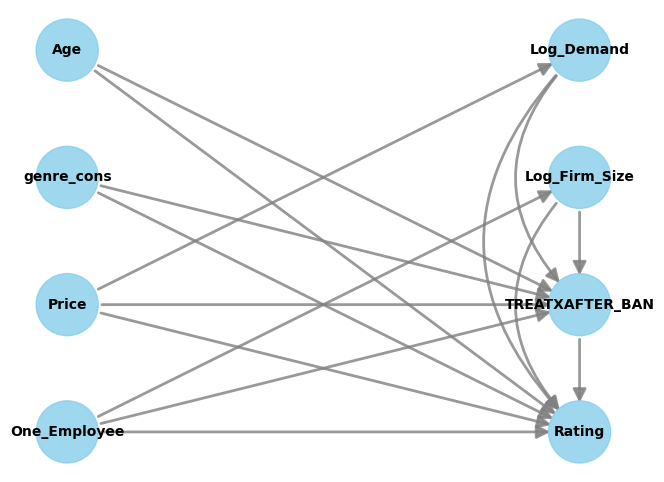

In [111]:
import warnings
from dowhy import CausalModel
warnings.filterwarnings("ignore")

treatment = 'TREATXAFTER_BAN'
outcome = 'Rating'
df = prepare_data()

model=CausalModel(
        data=df, 
        treatment=treatment, 
        outcome=outcome, 
        graph="""graph[directed 1
  node[id "Log_Demand" label "Log_Demand"]
  node[id "Age" label "Age"]
  node[id "genre_cons" label "genre_cons"]
  node[id "Price" label "Price"]
  node[id "One_Employee" label "One_Employee"]
  node[id "Log_Firm_Size" label "Log_Firm_Size"]
  node[id "TREATXAFTER_BAN" label "TREATXAFTER_BAN"]
  node[id "Rating" label "Rating"]
  
  edge[source "Log_Demand" target "TREATXAFTER_BAN"]
  edge[source "Age" target "TREATXAFTER_BAN"]
  edge[source "genre_cons" target "TREATXAFTER_BAN"]
  edge[source "Price" target "TREATXAFTER_BAN"]
  edge[source "One_Employee" target "TREATXAFTER_BAN"]
  edge[source "Log_Firm_Size" target "TREATXAFTER_BAN"]
  edge[source "Price" target "Log_Demand"]
  edge[source "One_Employee" target "Log_Firm_Size"]
  edge[source "Log_Demand" target "Rating"]
  edge[source "Age" target "Rating"]
  edge[source "genre_cons" target "Rating"]
  edge[source "Price" target "Rating"]
  edge[source "One_Employee" target "Rating"]
  edge[source "Log_Firm_Size" target "Rating"]
  edge[source "TREATXAFTER_BAN" target "Rating"]

]
"""

        )

model.view_model()

estimand = model.identify_effect()

estimate = model.estimate_effect(identified_estimand=estimand, 
                                 method_name="backdoor.linear_regression")

refute_subset = model.refute_estimate(estimand=estimand,
                                      estimate=estimate,
                                      method_name="data_subset_refuter",
                                      subset_fraction=0.4)

In [20]:
from sklearn.ensemble import GradientBoostingRegressor
import econml
from dowhy import CausalModel
from sklearn.linear_model import LassoCV

estimate_dml = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dml.DML',
    method_params={
        'init_params': {
            'model_y': GradientBoostingRegressor(),
            'model_t': GradientBoostingRegressor(),
            'model_final': LassoCV(fit_intercept=False),
        },
        'fit_params': {}}
)

print(f'Estimate of causal effect (DML): {estimate_dml.value}')

Estimate of causal effect (DML): -0.07501673838234835


In [21]:
estimate_lr = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.linear_regression')

print(f'Estimate of causal effect (linear regression): {estimate_lr.value}')

Estimate of causal effect (linear regression): -0.09991915835950049


In [22]:
random_cause = model.refute_estimate(
    estimand=estimand, 
    estimate=estimate,
    method_name='random_common_cause'
)
print(random_cause)

Refute: Add a random common cause
Estimated effect:-0.09991915835950049
New effect:-0.09991852670584914
p value:1.0



In [23]:
placebo_refuter = model.refute_estimate(
    estimand=estimand, 
    estimate=estimate,
    method_name='placebo_treatment_refuter'
)
print(placebo_refuter)

Refute: Use a Placebo Treatment
Estimated effect:-0.09991915835950049
New effect:-5.906386491005833e-13
p value:0.0



In [113]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV, lasso_path, enet_path, Ridge
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import numpy as np

def plot_coefficient_convergence(alphas, coefs, feature_names, title):
    """Plot the convergence of coefficients for each model with improved annotation."""
    plt.figure(figsize=(12, 8))
    
    # Limit the number of features to plot for readability
    max_features_to_plot = 20
    if len(feature_names) > max_features_to_plot:
        feature_names = feature_names[:max_features_to_plot]
        coefs = coefs[:max_features_to_plot]
    
    # Use a distinct color palette
    colors = plt.cm.tab20(np.linspace(0, 1, len(feature_names)))
    
    for coef, name, color in zip(coefs, feature_names, colors):
        plt.plot(np.log10(alphas), coef, label=name, color=color)
        # Annotate at the point where the absolute coefficient value is largest
        max_idx = np.argmax(np.abs(coef))
        plt.annotate(
            name, 
            (np.log10(alphas[max_idx]), coef[max_idx]), 
            fontsize=9, color=color,
            ha='left', va='center', 
            xytext=(5, 0), textcoords='offset points'
        )
    
    plt.xlabel('$\log_{10}(\lambda)$', fontsize=14)
    plt.ylabel('Coefficients', fontsize=14)
    plt.title(title, fontsize=16)
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def run_regularized_models(data):
    """Run LASSO, Ridge, and Elastic Net models"""
    indep_vars = [
        'Age', 'Bug_Fix',
        'Collects_User_ID', 'Feature_Update', 'File_Size', 'Firm_Size', 'Log_Demand',
        'Log_Firm_Size', 'Log_Price', 'One_Employee', 'Permissions',
        'Price', 'Update'
    ]

    # Ensure all independent variables are present in the data
    indep_vars = [var for var in indep_vars if var in data.columns]

    # Separate numeric and categorical variables
    numeric_vars = data[indep_vars].select_dtypes(include=['number']).columns.tolist()
    categorical_vars = data[indep_vars].select_dtypes(include=['category', 'object']).columns.tolist()

    # Handle categorical variables with detailed debugging
    X_categorical = pd.DataFrame()
    for var in categorical_vars:
        print(f"Handling variable: {var}")
        if pd.api.types.is_categorical_dtype(data[var]):
            print(f" - Current categories before adding 'missing': {data[var].cat.categories.tolist()}")
            if 'missing' not in data[var].cat.categories:
                data[var] = data[var].cat.add_categories(['missing'])
                print(f" - Added 'missing' category.")
            data[var] = data[var].fillna('missing')
            print(f" - Filled NaNs with 'missing'.")
            print(f" - Current categories after adding 'missing': {data[var].cat.categories.tolist()}")
        else:
            print(f" - Variable is not categorical. Converting to 'category' and adding 'missing'.")
            data[var] = data[var].fillna('missing').astype('category')
            if 'missing' not in data[var].cat.categories:
                data[var] = data[var].cat.add_categories(['missing'])
                print(f" - Added 'missing' category.")
            data[var] = data[var].fillna('missing')
            print(f" - Filled NaNs with 'missing'.")
            print(f" - Current categories after adding 'missing': {data[var].cat.categories.tolist()}")
        # Now data[var] has 'missing' filled
        X_categorical[var] = data[var]

    # Now encode categorical variables using one-hot encoding
    X_categorical_encoded = pd.get_dummies(X_categorical, drop_first=True)

    # Fill missing values in numeric variables
    X_numeric = data[numeric_vars].fillna(0)

    # Combine numeric and encoded categorical variables
    X = pd.concat([X_numeric, X_categorical_encoded], axis=1)

    # Prepare the target variable
    Y = data['Rating'].fillna(data['Rating'].mean())

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Define cross-validation strategy
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # LASSO Regression
    print("\nRunning LASSO Regression...")
    lasso_cv = LassoCV(cv=kfold, random_state=42, max_iter=10000)
    lasso_cv.fit(X_scaled, Y)
    best_alpha_lasso = lasso_cv.alpha_
    print(f"Optimal alpha for LASSO: {best_alpha_lasso}")

    # Compute LASSO path
    alphas_lasso, coefs_lasso, _ = lasso_path(X_scaled, Y, alphas=None)
    plot_coefficient_convergence(alphas_lasso, coefs_lasso, X.columns, "LASSO Regression Coefficients")

    # Ridge Regression
    print("\nRunning Ridge Regression...")
    ridge_cv = RidgeCV(cv=kfold, alphas=np.logspace(-5, 5, 100))
    ridge_cv.fit(X_scaled, Y)
    best_alpha_ridge = ridge_cv.alpha_
    print(f"Optimal alpha for Ridge: {best_alpha_ridge}")

    # Compute Ridge path
    alphas_ridge = np.logspace(2, 8, 100)
    coefs_ridge = []
    for alpha in alphas_ridge:
        ridge = Ridge(alpha=alpha, fit_intercept=True)
        ridge.fit(X_scaled, Y)
        coefs_ridge.append(ridge.coef_)
    coefs_ridge = np.array(coefs_ridge).T
    plot_coefficient_convergence(alphas_ridge, coefs_ridge, X.columns, "Ridge Regression Coefficients")

    # Elastic Net Regression
    print("\nRunning Elastic Net Regression...")
    elastic_net_cv = ElasticNetCV(cv=kfold, random_state=42, max_iter=10000, 
                                 l1_ratio=[.1, .5, .7, .9, .95, .99, 1])
    elastic_net_cv.fit(X_scaled, Y)
    best_alpha_enet = elastic_net_cv.alpha_
    best_l1_ratio_enet = elastic_net_cv.l1_ratio_
    print(f"Optimal alpha for Elastic Net: {best_alpha_enet}")
    print(f"Optimal l1_ratio for Elastic Net: {best_l1_ratio_enet}")

    # Compute Elastic Net path without 'fit_intercept'
    print("Computing Elastic Net path...")
    alphas_enet, coefs_enet, _ = enet_path(X_scaled, Y, l1_ratio=best_l1_ratio_enet)
    plot_coefficient_convergence(alphas_enet, coefs_enet, X.columns, "Elastic Net Regression Coefficients")

    return {
        'LASSO': lasso_cv,
        'Ridge': ridge_cv,
        'Elastic Net': elastic_net_cv
    }

def main():
    # Prepare the data
    df = prepare_data()
    
    # Run regularized models
    results = run_regularized_models(df)
    
    return results

if __name__ == "__main__":
    results = main()


ValueError: No objects to concatenate

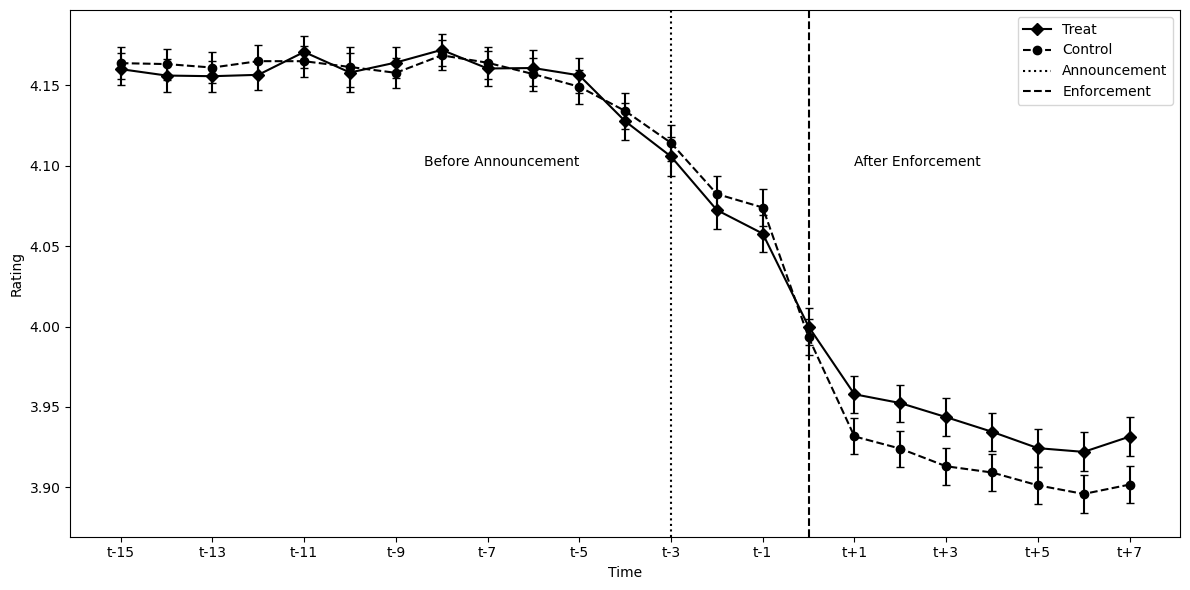

In [123]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data
df = prepare_data()

# Calculate the mean Rating and standard error for each group over time
def calc_stats(group):
    return pd.Series({
        'mean': group['Rating'].mean(),
        'se': group['Rating'].sem()
    })

treat_stats = df[df['ann_TREAT'] == 1].groupby('ym').apply(calc_stats).reset_index()
control_stats = df[df['ann_TREAT'] == 0].groupby('ym').apply(calc_stats).reset_index()

# Plot the graph
fig, ax = plt.subplots(figsize=(12, 6))

# Plot lines
ax.plot(treat_stats['ym'], treat_stats['mean'], color='black', linestyle='solid', marker='D', label='Treat')
ax.plot(control_stats['ym'], control_stats['mean'], color='black', linestyle='dashed', marker='o', label='Control')

# Add error bars
ax.errorbar(treat_stats['ym'], treat_stats['mean'], yerr=treat_stats['se'], 
            fmt='none', ecolor='black', capsize=3)
ax.errorbar(control_stats['ym'], control_stats['mean'], yerr=control_stats['se'], 
            fmt='none', ecolor='black', capsize=3)

ax.set_xlabel('Time')
ax.set_ylabel('Rating')

# Adjust x-ticks to span the entire graph with 't' as the benchmark
min_ym = int(min(treat_stats['ym'].min(), control_stats['ym'].min()))
max_ym = int(max(treat_stats['ym'].max(), control_stats['ym'].max()))
benchmark_ym = 715  # This was previously 't+3', now it's 't'

ym_range = list(range(min_ym, max_ym + 1, 2))  # Adjust step size if needed
labels = [f't{i - benchmark_ym:+d}' if i != benchmark_ym else 't' for i in ym_range]

ax.set_xticks(ym_range)
ax.set_xticklabels(labels)

ax.grid(False)
ax.axvline(712, color='black', linestyle='dotted', label='Announcement')
ax.axvline(715, color='black', linestyle='--', label='Enforcement')
ax.text(710, 4.1, 'Before Announcement', ha='right')
ax.text(716, 4.1, 'After Enforcement', ha='left')
ax.legend()

plt.tight_layout()
plt.savefig('fig_rating_with_se_adjusted.pdf')